# Pseudospectral methods tutorial, part 1
## UNCW, March 2017


A gentle stroll through pseudospectral methods: differentiating functions with the FFT.




## 1D domain - periodic functions on the real line  $f(x)$ 

First load the package for plotting.

In [19]:
using PyPlot

Create the physical grid $x$. For a domain of length $L_x$ with $n_x$ grid points the grid spacing is $\delta=L_x/n_x$. Our grid points then are: $x = 0,\delta, 2\delta,\dots,L_x-\delta$. Notice, that the final grid point *does not* correspond to $x=L_x$ but to $x=L_x-\delta$. This is because of periodicity: $f(L_x)=f(0)$.

Thus our grid points are $x_j = (j-1)\delta$, with $j=1,\dots,n_x$.

In [20]:
nx = 32
Lx = 2.0*pi

dx = Lx/nx
 x = 0:dx:Lx-dx;

Let's define a function, e.g., $f(x) = \sin(2x)+\frac1{2}\cos(5x)$. The approximation of this function on our $x$-grid is
$$f_j \equiv f(x_j),\text{ for }j=1,\dots,n_x$$
Let us see how well the array $f_j$ approximates the functio $f(x)$.

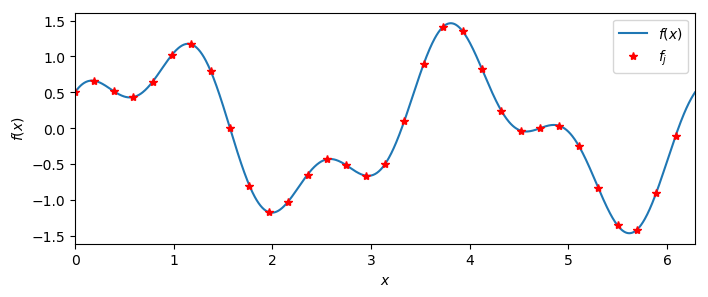

In [21]:
f = sin.(2*x) + 0.5*cos.(5*x)   # a test function f(x)


x_cont = linspace(0, Lx, 1001)         # a much fined x-grid
f_cont = sin.(2*x_cont) + 0.5*cos.(5*x_cont)   # the same function f(x) defined on the finer grid


figure(1, figsize=(8, 3) )
plot(x_cont, f_cont, linestyle="solid", label=L"f(x)")  # plots the abs value of fft of f(x)
plot(x, f, marker="*", color="r", linestyle="none", label=L"f_j")  # plots the abs value of fft of f(x)
legend()
xlim(0, Lx)
xlabel(L"x")
ylabel(L"f(x)");

The derivative of the above function is $df/dx = 2\cos(2x)-\frac5{2}\sin(5x)$. Let us pretend that we do not know the derivative and instead try to compute it numerically. 

(When we are coding something new we should \emph{always} try to start with something we know what the answer should be so we can compare our numerical results. This step may seem obvious, but, nonetheless, it is ofter overlooked by most people...)

The simplest approximation for the array of the derivative $(df/dx)_j$ is the, so called, centered finite differences:
$$\left(\frac{df}{dx}\right)_j = \frac{f_{j+1}-f_{j-1}}{2\delta},\text{ for }j=2,\dots,n_x-1.$$

Let's see how this approximation compares with the actual derivative.

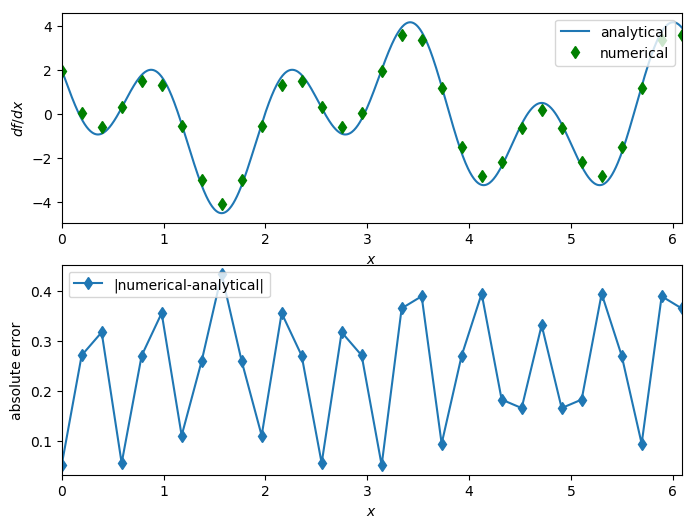

In [22]:
# the analytical expression for df/dx
dfdx_an = 2*cos.(2*x) - 2.5*sin.(5*x)

# the analytical expression for df/dx computed on the finer grid (for plotting purposes)
dfdx_an_cont = 2*cos.(2*x_cont) - 2.5*sin.(5*x_cont)   

# the finite differences approximation
dfdx_fd = zeros(nx)
for j in 2:nx-1
    dfdx_fd[j] = (f[j+1]- f[j-1])/(2*dx)
end
# for the j=1 and j=nx grid points we use the fact that f(x) is periodic!
dfdx_fd[1]  = (f[2] - f[nx])  /(2*dx)
dfdx_fd[nx] = (f[1] - f[nx-1])/(2*dx)



# Plot (df/dx)_j and compare with the actual df/dx

fig, axs = subplots(nrows=2, ncols=1, figsize=(8, 6) )

sca(axs[1])
plot(x_cont, dfdx_an_cont, label="analytical")
plot(x, dfdx_fd, marker="d", color="g", linestyle="none", label="numerical")

xlabel(L"x")
ylabel(L"df / dx")
legend(loc="upper right", fancybox="true")
xlim(0, Lx-dx)

sca(axs[2])
plot(x, abs.(dfdx_an - dfdx_fd), marker="d", label="|numerical-analytical|")
legend(loc="upper left", fancybox="true")
xlabel(L"x")
ylabel("absolute error")
xlim(0, Lx-dx);


We see that the error at each grid-point is of order $10^{-1}$. If we increase the number of grid-points of course the error will decrease.

The error should decrease as $n_x^2$, i.e. if we increase the numbers of grid-points by a factor of $10$ the error should decrease by a factor of $10^2$. This is OK, but we can do _much better_ using **spectral methods**.


To start, let's remember that any periodic and differentiable function defined on the domain $0\le x\le L_x$ can be expanded as a Fourier series:
$$ f(x) = \sum_{k_x} \hat{\;f}_{k_x}\,e^{i k_x x},$$
where the wavenumbers $k_x=\frac{2\pi}{L_x}[0,1,2,\dots]$. The coefficents $\hat{\;f}_{k_x}$ are
$$\hat{\;f}_{k_x} = \frac1{L_x}\int_{0}^{L_x} f(x)\,e^{-i k_x x}\,dx.$$

The derivative is trivially expressed as a Fourier series as:
$$ \frac{df}{dx} = \sum_{k_x} i k_x \hat{\;f}_{k_x}\,e^{i k_x x}.$$
(Just differentiate the right-hand-side of the expression for $f(x)$.)


Our function $f$ is, conveniently, already expanded as a Fourier series so we can read off the coefficients $\hat{\;f}_{k_x}$:
$$\hat{\;f}_{k_x}=\begin{cases}
                        \frac1{2i} \quad\text{if $k_x=4\pi/L_x$,} \\
                        -\frac1{2i} \quad\text{if $k_x=-4\pi/L_x$,} \\
                        \frac1{4} \quad\text{if $k_x=10\pi/L_x$,} \\
                        \frac1{4} \quad\text{if $k_x=-10\pi/L_x$,} \\
                        0 \quad\text{otherwise.} \\
                        \end{cases}$$
                        
**Exercise**: Use the coefficients above and compute the Fourier series for $\sum_{k_x} i k_x \hat{\;f}_{k_x}\,e^{i k_x x}$. Do you recover the analytical expression for $df/dx$?

If our function $f$ was not as simple and thus we could not read off the coefficients $\hat{\;f}_{k_x}$ from $f$ then we can get them by computing the integral above (or by approximating the integral numerically). Fortunately though, we don't have to do that. There exist the Fast Fourier Transform (`fft`) algorithm (which is included in Matlab, Python, Julia, etc). This algorithm is very well optimized, i.e., it is much faster than actually approximating the integral numerically. We can obtain the coefficents $\hat{\;f}_{k_x}$ using `fft` as:
$$
\mathtt{fft}(f) = \hat{\;f}_{k_x}\,n_x.
$$
Multiplication with $n_x$ on the right-hand-side above is due to the normalization that `fft` algorithm uses. Furthermore, with the inverse, `ifft` we can compute $f$ from $\hat{\;f}_{k_x}$.
$$
\mathtt{ifft}(\hat{\;f}_{k_x}) = f\big/n_x.
$$



With the coefficients $\hat{\;f}_{k_x}$ in hand we compute $df/dx$ as
$$\frac{df}{dx}  = \mathtt{ifft}\left[ i k_x \mathtt{fft}(f)\right] .$$

Let us see how well the numerical approximation of the derivative using spectral methods compares with the actual analytical expression for $df/dx$.

In [23]:
# the k_x wavenumbers in the order that the FFT algorithm assumes
kx  = 2.0*pi/Lx * cat(1, 0:nx/2, -nx/2+1:-1);

      fh = fft(f)                      # the FFT of f(x)
dfdx_num = real(ifft(im*kx.*fh));      # the numerical approximation for df/dx

Note that after we used `ifft` we also took the real part. We do that to remove any imaginary parts that the algoritm might introduce (which should be of order $10^{-16}$).

First we plot the coefficients $\hat{\;f}_{k_x}$ obtained using the `fft` algorithm. Do we see power at the wavenumbers we were expecting?

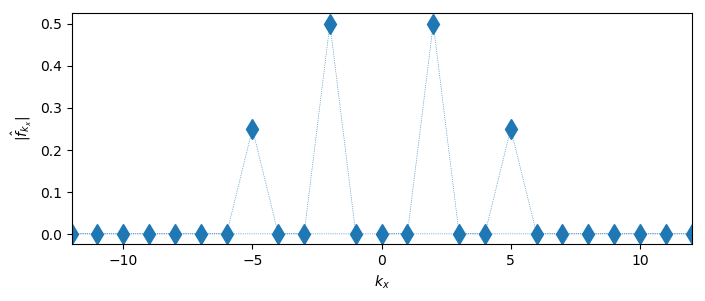

In [24]:
figure(1, figsize=(8, 3) )
plot(kx, abs.(fh)/nx, marker="d", markersize=10, linestyle=":", linewidth=0.5)  # plots the abs value of fft of f(x)
xlim(-12, 12)
xlabel(L"k_x")
ylabel(L"|\hat{f}_{k_x}|");

Now let's compare the numerical approximation of $df/dx$ with the analytical one.

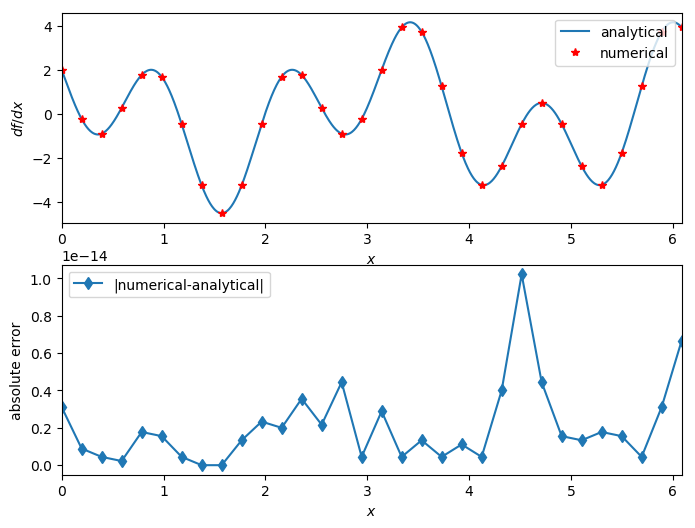

In [25]:
fig, axs = subplots(nrows=2, ncols=1, figsize=(8, 6) )

sca(axs[1])
plot(x_cont, dfdx_an_cont, label="analytical")
plot(x, dfdx_num, marker="*", color="r", linestyle="none", label="numerical")

xlabel(L"x")
ylabel(L"df / dx")
legend(loc="upper right", fancybox="true")
xlim(0, Lx-dx)

sca(axs[2])
plot(x, abs.(dfdx_an - dfdx_num), marker="d", label="|numerical-analytical|")
legend(loc="upper left", fancybox="true")
xlabel(L"x")
ylabel("absolute error")
xlim(0, Lx-dx);

Wow!

See how much better accuracy we got now? We got an error of (nearly) machine precission. And we obtained this just with only $n_x=32$ points. Try doing that with finite differences...

(The error with finite differences using $n_x=10^{20}\approx 1000000$ points is still about $10^{-10}$, i.e., $10^4$ larger!)

**Exercise**: Can we perhaps push spectral methods even further? What about if we had $n_x=16$ points? How far can we decreasee the resolution and still evaluate $df/dx$ with such good accuracy?

## 2D domain - functions  $\ f(x,y)$ 

Let's apply the same principles on a two-dimensional domain.

First, we  create the physical grid $x$, $y$. It is instructive to take different domain lengths, $L_x$ and $L_y$ and different grid points in each direction, $n_x$, $n_y$. This way make sure that we treat each dimension correctly.

In [26]:
nx, ny = 64, 32               # number of grid points
Lx, Ly = 2.0*pi, 1.0*pi       # size of the domain in each direction

# constructing the physical grid (x,y)
dx, dy = Lx/nx, Ly/ny
 x = 0:dx:Lx-dx
 y = 0:dy:Ly-dy

X  = zeros(nx,ny)
Y  = zeros(nx,ny)
for j in 1:ny, i in 1:nx
    X[i,j], Y[i, j] = x[i], y[j]
end

# constructing the wavenumber grid (k,l)
k  = 2.0*pi/Lx * cat(1, 0:nx/2, -nx/2+1:-1);
l  = 2.0*pi/Ly * cat(1, 0:ny/2, -ny/2+1:-1);

k0 = 2.0*pi/Lx            # the fundamental x-wavenumber
l0 = 2.0*pi/Ly            # the fundamental y-wavenumber

K = zeros(nx, ny)
L = zeros(nx, ny)
for j in 1:ny, i in 1:nx
    K[i, j], L[i, j] = k[i], l[j]
end

Now let's define a two-dimensional function
$$f(x,y) = \cos\left(3\frac{2\pi}{Lx} x\right)\sin\left(2\frac{2\pi}{Ly} y\right),$$
compute $\partial f/\partial y$ numerically and compare with the analytical expression.

In [27]:
mx, my = 3, 2
f = cos.(mx*k0*X).*sin.(my*l0*Y)
fh = fft(f)

dfdy_an  = my*l0*cos.(mx*k0*X).*cos.(my*l0*Y)
dfdy_num = real(ifft(im*L.*fh));

**Exercise:** Plot the two-dimensional power spectra of $f$: $|\hat{\;f}_{k_x,k_y}|$. Is it how you expexted it to be?
(Regarding normalization, the coefficients $\hat{\;f}_{k_x,k_y} = \mathtt{fft}(f)\,n_x n_y$.)

Now, as we did before, let's plot the numerical and analytical $\partial f/\partial y$ and compare. If all is good, we should expect machine precision error...

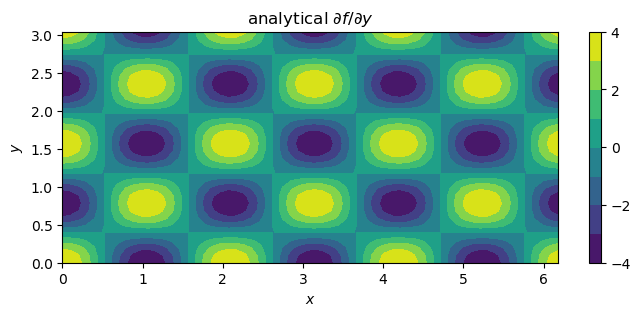

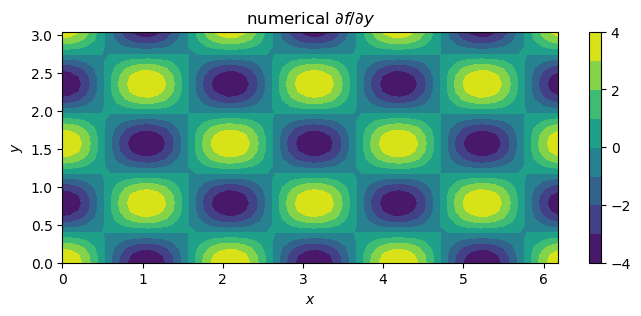

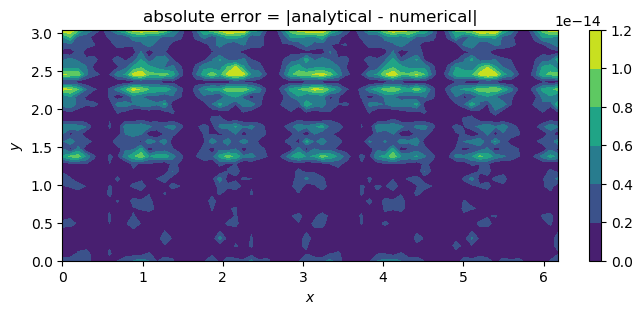

In [28]:
levs = -4:1:4   # the contour levels for the plots of \partial f/\partial y

# contour plot of the analytical \partial f/\partial y
figure(figsize=(8, 3))

contourf(X, Y, dfdy_an, levs, label="analytical")  # notice that contour levels are prescribed
xlabel(L"$x$")
ylabel(L"$y$")
title(L"analytical $\partial f/\partial y$")
xlim(0, Lx-dx)
ylim(0, Ly-dy)
clim(-4,4)
colorbar(ticks=-4:2:4)

# contour plot of the numerical approcimation to \partial f/\partial y
figure(figsize=(8, 3))
contourf(X, Y, dfdy_num, levs, label="numerical")

xlabel(L"$x$")
ylabel(L"$y$")
title(L"numerical $\partial f/\partial y$")
xlim(0, Lx-dx)
ylim(0, Ly-dy)
clim(-4,4)
colorbar(ticks=-4:2:4)

# contour plot of the absolute error
figure(figsize=(8, 3))
contourf(X, Y, abs.(dfdy_an - dfdy_num), label="error")

xlabel(L"$x$")
ylabel(L"$y$")
title("absolute error = |analytical - numerical|")
xlim(0, Lx-dx)
ylim(0, Ly-dy)
colorbar();

What's your favorite number? Mine is $10^{-16}$; this is the machine precision with 64-bit arithmetic. When I see that probably I know I did everything correct. (Often if I see just plain $0$ the usually something's going wrong.)

Do we get machine precision if we calculate the relative error that we made with our approximation?

In [29]:
rel_error = abs.(maximum(abs.(dfdy_an)) - maximum(abs.(dfdy_num)))/maximum(abs.(dfdy_an))

8.881784197001252e-16

Sure we do...